In [1]:
####### Run a simple analysis of terrain around a selected location

# Step 1: Sign up for a Google Earth Engine Account here:
# https://earthengine.google.com/signup/

# you will use this to authenticate your account with GEE to run the script and
# utilize GEE layers

# Step 2: Setup a local conda environment on your machine to run Python and GEE

# Step 3: Install python, geemap, earthengine-api and pandas in your conda environment

# Step 4: Install python, jupyterlab, matplotlib, geemap, earthengine-api and pandas in your conda environment
# https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html

# Step 5: Launch jupyter-lab and open the Ipython script

# Step 6: Run through the tutorial script

In [2]:
# get any missing modules
! pip install --quiet numpy matplotlib earthengine-api geemap pandas 

In [3]:
# setup modules
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
import pandas as pd
import sys,os,os.path,tempfile

# spatial modules
import ee
#import geemap # currently not using as colorbars dont load properly in google collab
import geemap.colormaps as cm
import geemap.foliumap as geemap # use folium instead so coloramps work on goolge collab
#import geemap as geemap
#https://geemap.org/notebooks/geemap_and_folium/
#https://geemap.org/notebooks/49_colorbar/#categorical-colorbar
    
import warnings
warnings.filterwarnings('ignore') #don't display warnings

In [4]:
## setup output. defined dir or system temp dir
output_dir=os.path.expanduser(os.path.join(tempfile.gettempdir(),'uas_output'))

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(" ")
print("****** Temporary Output Folder ******")
print("****** Note: In Google Collab, use the dir navigation tool on the left of the screen ******")
print(output_dir)

 
****** Temporary Output Folder ******
****** Note: In Google Collab, use the dir navigation tool on the left of the screen ******
/var/folders/xp/h3k9vf3n2jx181ts786_yjrn9c2gjq/T/uas_output


In [ ]:
##### initialize ee API  - you need to authenticate with GEE and initialize

## Trigger the authentication flow. You only need to do this once while running notebook
ee.Authenticate()

## After inserting the API key initialize GEE
ee.Initialize()

In [6]:
##### Link to Example Cloud Optimized GeoTiffs (COGs) located in a Google Cloud Storage "bucket"
URL = 'gs://bnl_uas_data/council_watershed_pft_30m_cog.tif'
counc_30m_pft_map = geemap.load_GeoTIFF(URL).select("B0")
mask = counc_30m_pft_map.gt(0);
counc_30m_pft_map = counc_30m_pft_map.updateMask(mask);

#Define a palette for the distinct PFT classes.
pft_palette = [
    '000000',#background
    'ff0000', #Spruce
    '008000', #AlderShrub
    '00cc00', #WillowShrub
    '669999', #OhterTallShrub
    '0066ff', #LowShrub
    'ffff66', #DwarfShrub
    '66ffff', #EvergreenShrub
    '00b0f0', #Forb
    '00ff67', #DryGraminoid
    'ff67ff', #WetGraminoid
    'cc6600', #Moss
    'ffffff', #Lichen
    '6d6d6d' #NPV
]
pftViz = {'min': 0, 'max': 13, 'palette': pft_palette}
legend_keys = ['Spruce', 'AlderShrub', 'WillowShrub', 'OhterTallShrub', 'LowShrub',
               'DwarfShrub', 'EvergreenShrub', 'Forb', 'DryGraminoid',
               'WetGraminoid', 'Moss','Lichen', 'NPV']
legend_colors = ['#ff0000', '#008000', '#00cc00', '#669999', '#0066ff', 
                '#ffff66','#66ffff','#00b0f0','#00ff67','#ff67ff','#cc6600','#ffffff',
                '#6d6d6d']

In [7]:
##### Create a simple map displaying an RGB UAS image (Yang et al., 2022)
# center map over the Council Study Site
pft_map = geemap.Map(center=[64.857595,-163.693854], zoom=13);
pft_map.addLayer(counc_30m_pft_map, pftViz, '30m PFT Map')
pft_map.add_legend(title="30m UAS+AVIRIS-NG NGEE PFT Classification",
                   labels=legend_keys, colors=legend_colors, position='bottomleft')
pft_map

In [8]:
##### Get Landsat 8 NDVI max data
l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_8DAY_NDVI').filterDate('2018-07-01', '2018-09-10')
l8_ndvi = l8.select('NDVI');
#water = l8_ndvi.first().lt(0.5)
#mask = water.eq(1);

# Composite and drop values == 1
l8_maxval_ndvi_composite = l8_ndvi.max()
l8mask = l8_maxval_ndvi_composite.lt(1)
l8_maxval_ndvi_composite = l8_maxval_ndvi_composite.updateMask(l8mask)

In [9]:
##### Create pixel mask by PFT
# Spruce
spruce_mask = counc_30m_pft_map.eq(1);
# Alder
alder_mask = counc_30m_pft_map.eq(2);
# Willow
willow_mask = counc_30m_pft_map.eq(3);
# Low Shrub
lowshrub_mask = counc_30m_pft_map.eq(5);
# Graminoids
dg_mask = counc_30m_pft_map.eq(9);
graminoid_mask = counc_30m_pft_map.eq(10).add(dg_mask);

In [10]:
##### Select out only those pixels per PFT
# Spruce
spruce_l8_maxval_ndvi = l8_maxval_ndvi_composite.updateMask(spruce_mask)
# Alder
alder_l8_maxval_ndvi = l8_maxval_ndvi_composite.updateMask(alder_mask)
# Willow
willow_l8_maxval_ndvi = l8_maxval_ndvi_composite.updateMask(willow_mask)
# Low shrubs
lowshrub_l8_maxval_ndvi = l8_maxval_ndvi_composite.updateMask(lowshrub_mask)
# Graminoids
graminoid_l8_maxval_ndvi = l8_maxval_ndvi_composite.updateMask(graminoid_mask)


# Show the alder pixels
roi = ee.Geometry.Polygon([[[-163.791904,64.873148], [-163.637409,64.87169], [-163.639126,64.829743],
                          [-163.793278,64.83113]]], None, False)
ndvi_palette = cm.get_palette('viridis', n_class=30)
ndviViz = {'min': 0.0, 'max': 0.9, 'palette': ndvi_palette, 'opacity': 1}
l8_ndvi_map = geemap.Map(center=[64.857595,-163.693854], zoom=12);
l8_ndvi_map.addLayer(lowshrub_l8_maxval_ndvi, ndviViz, 'Subset Landsat 8 Max NDVI by Class')
l8_ndvi_map.add_colorbar(vis_params=ndviViz, label='Landsat 8 NDVI (-)')
l8_ndvi_map.addLayer(roi, {'color': '000000', 'strokeWidth': 3, 'oppacity': 0.9}, "PFT Map Area")
l8_ndvi_map

In [11]:
##### Extract the data
# Spruce
spruce_pixels = geemap.ee_to_pandas(geemap.random_sampling(spruce_l8_maxval_ndvi.reproject(crs=ee.Projection('EPSG:3395')), roi, numPixels=5000))
# Alder
alder_pixels = geemap.ee_to_pandas(geemap.random_sampling(alder_l8_maxval_ndvi.reproject(crs=ee.Projection('EPSG:3395')), roi, numPixels=5000))
# Willow
willow_pixels = geemap.ee_to_pandas(geemap.random_sampling(willow_l8_maxval_ndvi.reproject(crs=ee.Projection('EPSG:3395')), roi, numPixels=5000))
# Low shrubs
lowshrub_pixels = geemap.ee_to_pandas(geemap.random_sampling(lowshrub_l8_maxval_ndvi.reproject(crs=ee.Projection('EPSG:3395')), roi, numPixels=5000))
# Graminoids
graminoid_pixels = geemap.ee_to_pandas(geemap.random_sampling(graminoid_l8_maxval_ndvi.reproject(crs=ee.Projection('EPSG:3395')), roi, numPixels=5000))

In [14]:
##### Show an example of the randomly selected points
# This shows the pixels selected to extract NDVI data
example_rand_points = geemap.random_sampling(willow_l8_maxval_ndvi.reproject(crs=ee.Projection('EPSG:3395')), roi, numPixels=5000)
ndvi_palette = cm.get_palette('viridis', n_class=30)
ndviViz = {'min': 0.0, 'max': 1.0, 'palette': ndvi_palette, 'opacity': 1}
l8_ndvi_map = geemap.Map(center=[64.857595,-163.693854], zoom=12);
l8_ndvi_map.addLayer(willow_l8_maxval_ndvi, ndviViz, 'Subset Landsat 8 Max NDVI by Class')
l8_ndvi_map.add_colorbar(vis_params=ndviViz, label='Landsat 8 NDVI (-)')
l8_ndvi_map.addLayer(roi, {'color': 'black', 'size': '50'}, "NGEE Sites")
l8_ndvi_map.addLayer(example_rand_points, {}, "points")
l8_ndvi_map

In [15]:
##### Combine pixel data
df = [spruce_pixels["NDVI"], alder_pixels["NDVI"], willow_pixels["NDVI"], lowshrub_pixels["NDVI"], graminoid_pixels["NDVI"], ]
headers = ["Spruce", "Alder", "Willow", "Low_Shrubs", "Graminoid"]
pixel_ndvi_data = pd.concat(df, axis=1, keys=headers)

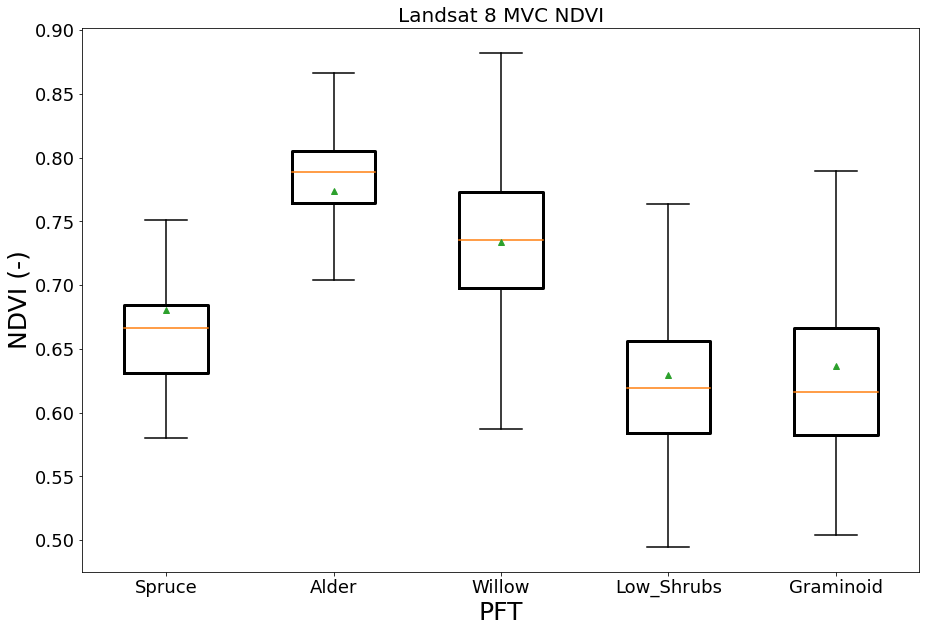

In [16]:
##### Plot the Max NDVI by select Arctic PFTs
fig = pl.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
boxplot = pixel_ndvi_data.boxplot(column=headers, 
                      color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
                      showmeans=True,boxprops=dict(linestyle='-', linewidth=3),
                      flierprops=dict(linestyle='-', linewidth=1.5),
                      medianprops=dict(linestyle='-', linewidth=1.5),
                      whiskerprops=dict(linestyle='-', linewidth=1.5),
                      capprops=dict(linestyle='-', linewidth=1.5),
                      showfliers=False, grid=False, rot=0)
ax.set_title('Landsat 8 MVC NDVI', size=20)
ax.set_xlabel('PFT', size=25)
ax.set_ylabel('NDVI (-)', size=25)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)


# save to PNG file
png_file = os.path.join(output_dir, 'Landsat8_MaxNDVI_by_PFT.png')
ax.figure.savefig(png_file)

In [17]:
##### Get MODIS phenology - Use to compare basic phenology metrics by PFT
modis_pheno = ee.ImageCollection('MODIS/006/MCD12Q2').filter(ee.Filter.date('2018-01-01', '2019-01-01'));
vegetationGU = modis_pheno.select('Greenup_1');
vegetationPeak = modis_pheno.select('Peak_1');

In [18]:
##### Prep the MODIS data for comparison
mediangu = vegetationGU.median();
# Spruce
spruce_gu_date = mediangu.updateMask(spruce_mask)
# Alder
alder_gu_date = mediangu.updateMask(alder_mask)
# Willow
willow_gu_date = mediangu.updateMask(willow_mask)
# Low shrubs
lowshrub_gu_date = mediangu.updateMask(lowshrub_mask)
# Graminoids
graminoid_gu_date = mediangu.updateMask(graminoid_mask)

In [19]:
##### Extract the data
# Spruce
spruce_gu_pixels = geemap.ee_to_pandas(geemap.random_sampling(spruce_gu_date.reproject(crs=ee.Projection('EPSG:3395')), roi, numPixels=5000))
# Alder
alder_gu_pixels = geemap.ee_to_pandas(geemap.random_sampling(alder_gu_date.reproject(crs=ee.Projection('EPSG:3395')), roi, numPixels=5000))
# Willow
willow_gu_pixels = geemap.ee_to_pandas(geemap.random_sampling(willow_gu_date.reproject(crs=ee.Projection('EPSG:3395')), roi, numPixels=5000))
# Low shrubs
lowshrub_gu_pixels = geemap.ee_to_pandas(geemap.random_sampling(lowshrub_gu_date.reproject(crs=ee.Projection('EPSG:3395')), roi, numPixels=5000))
# Graminoids
graminoid_gu_pixels = geemap.ee_to_pandas(geemap.random_sampling(graminoid_gu_date.reproject(crs=ee.Projection('EPSG:3395')), roi, numPixels=5000))

In [20]:
##### Combine pixel data
df = [spruce_gu_pixels["Greenup_1"], alder_gu_pixels["Greenup_1"], willow_gu_pixels["Greenup_1"], lowshrub_gu_pixels["Greenup_1"], graminoid_gu_pixels["Greenup_1"]]
headers = ["Spruce", "Alder", "Willow", "Low_Shrubs", "Graminoid"]
pixel_gu_data = pd.concat(df, axis=1, keys=headers)

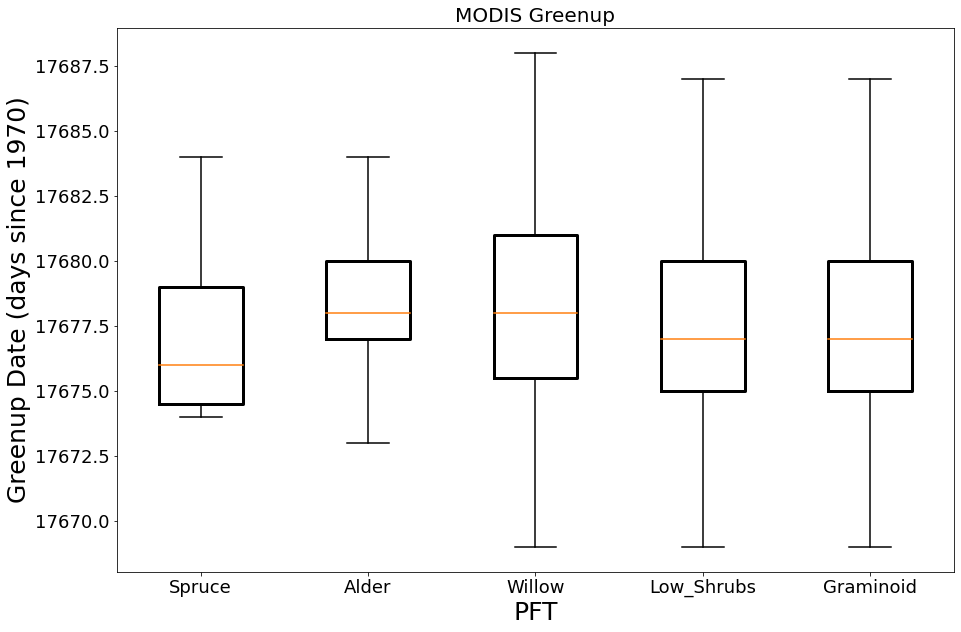

In [21]:
##### Plot the MODIS Greenup Dates by Select Arctic PFTs
fig = pl.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
boxplot = pixel_gu_data.boxplot(column=headers, 
                      color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
                      showmeans=False,boxprops=dict(linestyle='-', linewidth=3),
                      flierprops=dict(linestyle='-', linewidth=1.5),
                      medianprops=dict(linestyle='-', linewidth=1.5),
                      whiskerprops=dict(linestyle='-', linewidth=1.5),
                      capprops=dict(linestyle='-', linewidth=1.5),
                      showfliers=False, grid=False, rot=0)
ax.set_title('MODIS Greenup', size=20)
ax.set_xlabel('PFT', size=25)
ax.set_ylabel('Greenup Date (days since 1970)', size=25)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)

# save to PNG file
png_file = os.path.join(output_dir, 'MODIS_Greenup_2018_by_PFT.png')
ax.figure.savefig(png_file)

In [22]:
##### Prep the MODIS data for comparison
medianpeak = vegetationPeak.median();

# Spruce
spruce_peak_date = medianpeak.updateMask(spruce_mask)
# Alder
alder_peak_date = medianpeak.updateMask(alder_mask)
# Willow
willow_peak_date = medianpeak.updateMask(willow_mask)
# Low shrubs
lowshrub_peak_date = medianpeak.updateMask(lowshrub_mask)
# Graminoids
graminoid_peak_date = medianpeak.updateMask(graminoid_mask)

In [23]:
##### Extract the data
# Spruce
spruce_peak_pixels = geemap.ee_to_pandas(geemap.random_sampling(spruce_peak_date.reproject(crs=ee.Projection('EPSG:3395')), roi, numPixels=5000))
# Alder
alder_peak_pixels = geemap.ee_to_pandas(geemap.random_sampling(alder_peak_date.reproject(crs=ee.Projection('EPSG:3395')), roi, numPixels=5000))
# Willow
willow_peak_pixels = geemap.ee_to_pandas(geemap.random_sampling(willow_peak_date.reproject(crs=ee.Projection('EPSG:3395')), roi, numPixels=5000))
# Low shrubs
lowshrub_peak_pixels = geemap.ee_to_pandas(geemap.random_sampling(lowshrub_peak_date.reproject(crs=ee.Projection('EPSG:3395')), roi, numPixels=5000))
# Graminoids
graminoid_peak_pixels = geemap.ee_to_pandas(geemap.random_sampling(graminoid_peak_date.reproject(crs=ee.Projection('EPSG:3395')), roi, numPixels=5000))

In [24]:
##### Combine pixel data
df = [spruce_peak_pixels["Peak_1"], alder_peak_pixels["Peak_1"], willow_peak_pixels["Peak_1"], lowshrub_peak_pixels["Peak_1"], 
      graminoid_peak_pixels["Peak_1"]]
headers = ["Spruce", "Alder", "Willow", "Low_Shrubs", "Graminoid"]
pixel_peak_data = pd.concat(df, axis=1, keys=headers)

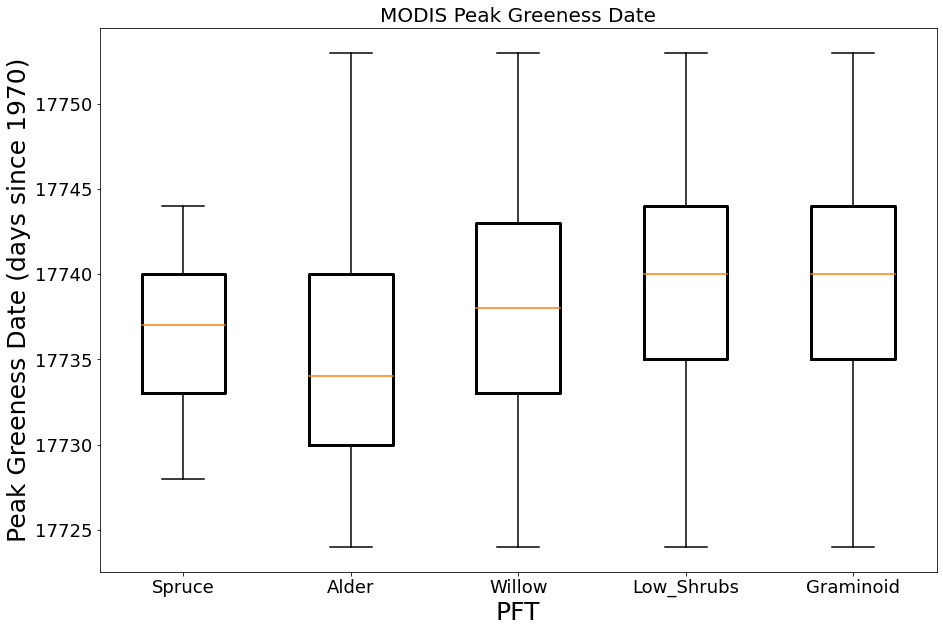

In [25]:
##### Plot the MODIS Peak Greeness Dates by Select Arctic PFTs
fig = pl.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
boxplot = pixel_peak_data.boxplot(column=headers, 
                      color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
                      showmeans=False,boxprops=dict(linestyle='-', linewidth=3),
                      flierprops=dict(linestyle='-', linewidth=1.5),
                      medianprops=dict(linestyle='-', linewidth=1.5),
                      whiskerprops=dict(linestyle='-', linewidth=1.5),
                      capprops=dict(linestyle='-', linewidth=1.5),
                      showfliers=False, grid=False, rot=0)
ax.set_title('MODIS Peak Greeness Date', size=20)
ax.set_xlabel('PFT', size=25)
ax.set_ylabel('Peak Greeness Date (days since 1970)', size=25)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)

# save to PNG file
png_file = os.path.join(output_dir, 'MODIS_Peak_Greeness_2018_by_PFT.png')
ax.figure.savefig(png_file)